# Model Halves-PMA -- Fixed Before Conditional Trials

In [1]:
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")

#removed WMAZE_007 due to lack of 2nd level late_nonlearn
sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
        'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

##STEP 1
proj_dir = '/home/data/madlab/Mattfeld_WMAZE/' 
mask_files = []
cope_files = []
for SID in sids:
    mask_files_glob = glob(proj_dir+'/derivatives/roi_masks/hamm/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_files.append(sorted(mask_files_glob))
    subjcopes_glob = glob(proj_dir+'/Hamm_Learning/HPMA/lvl2/fixed/' + SID + '/fixedfx/cope_*')
    cope_files.append(sorted(subjcopes_glob))  
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 18: 
        print(SID)

## Double-check the array indexing

In [2]:
##STEP 2a
for i, curr_mask in enumerate(mask_files[0]):
    print(i, mask_files[0][i].split('/')[-1][:-7]) #use enumerate to get index, use split to get filename 

0 lh-all_mPFC_warped
1 lh-dlPFC_warped
2 lh-dmPFC_warped
3 lh-hippocampus_warped
4 lh-mPFC_fs-3reg_warped
5 lh-mPFC_fs_warped
6 lh-mPFC_lausanne_warped
7 lh-motor_warped
8 lh-parsT_warped
9 lh_caudate_anat_mask_warped
10 lh_insula_warped
11 lh_vocc_warped
12 rh_caudate_anat_mask_warped
13 rh-all_mPFC_warped
14 rh-dlPFC_warped
15 rh-dmPFC_warped
16 rh-hippocampus_warped
17 rh-mPFC_fs-3reg_warped
18 rh-mPFC_fs_warped
19 rh-mPFC_lausanne_warped
20 rh-motor_warped
21 rh-parsT_warped
22 rh_insula_warped
23 rh_vocc_warped
24 lh-putamen_warped
25 lh_dlpfc_warped
26 lh_dlpfc_warped
27 rh-putamen_warped


In [3]:
##STEP 2b
for i, curr_cope in enumerate(cope_files[5]):
    print(i, cope_files[5][i].split('/')[-1][5:-7]) 

0 AllVsBase
1 all_remaining
2 early_learn_event
3 early_learn_pmod
4 early_nonlearn_event
5 early_nonlearn_pmod
6 event_early_learn_minus_pmod_early_learn
7 event_early_nonlearn_minus_pmod_early_nonlearn
8 event_late_learn_minus_pmod_late_learn
9 event_late_nonlearn_minus_pmod_late_nonlearn
10 late_learn_event
11 late_learn_pmod
12 late_nonlearn_event
13 late_nonlearn_pmod
14 pmod_early_learn_minus_event_early_learn
15 pmod_early_nonlearn_minus_event_early_nonlearn
16 pmod_late_learn_minus_event_late_learn
17 pmod_late_nonlearn_minus_event_late_nonlearn


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
##STEP 3
all_data = {'subjid':[],
            #HPC
            'lhhp_early_learn_event':[], 'rhhp_early_learn_event':[], 
            'lhhp_late_learn_event':[], 'rhhp_late_learn_event':[],
            'lhhp_early_nonlearn_event':[], 'rhhp_early_nonlearn_event':[],
            'lhhp_late_nonlearn_event':[], 'rhhp_late_nonlearn_event':[],
            'lhhp_early_learn_pmod':[], 'rhhp_early_learn_pmod':[], 
            'lhhp_late_learn_pmod':[], 'rhhp_late_learn_pmod':[],
            'lhhp_early_nonlearn_pmod':[], 'rhhp_early_nonlearn_pmod':[],
            'lhhp_late_nonlearn_pmod':[], 'rhhp_late_nonlearn_pmod':[],
            #mPFC
            'lhmpfc_early_learn_event':[], 'rhmpfc_early_learn_event':[], 
            'lhmpfc_late_learn_event':[], 'rhmpfc_late_learn_event':[],
            'lhmpfc_early_nonlearn_event':[], 'rhmpfc_early_nonlearn_event':[],
            'lhmpfc_late_nonlearn_event':[], 'rhmpfc_late_nonlearn_event':[],
            'lhmpfc_early_learn_pmod':[], 'rhmpfc_early_learn_pmod':[], 
            'lhmpfc_late_learn_pmod':[], 'rhmpfc_late_learn_pmod':[],
            'lhmpfc_early_nonlearn_pmod':[], 'rhmpfc_early_nonlearn_pmod':[],
            'lhmpfc_late_nonlearn_pmod':[], 'rhmpfc_late_nonlearn_pmod':[],
            #Caudate
            'lhcaud_early_learn_event':[], 'rhcaud_early_learn_event':[], 
            'lhcaud_late_learn_event':[], 'rhcaud_late_learn_event':[],
            'lhcaud_early_nonlearn_event':[], 'rhcaud_early_nonlearn_event':[],
            'lhcaud_late_nonlearn_event':[], 'rhcaud_late_nonlearn_event':[],
            'lhcaud_early_learn_pmod':[], 'rhcaud_early_learn_pmod':[], 
            'lhcaud_late_learn_pmod':[], 'rhcaud_late_learn_pmod':[],
            'lhcaud_early_nonlearn_pmod':[], 'rhcaud_early_nonlearn_pmod':[],
            'lhcaud_late_nonlearn_pmod':[], 'rhcaud_late_nonlearn_pmod':[],
            #Putamen
            'lhput_early_learn_event':[], 'rhput_early_learn_event':[], 
            'lhput_late_learn_event':[], 'rhput_late_learn_event':[],
            'lhput_early_nonlearn_event':[], 'rhput_early_nonlearn_event':[],
            'lhput_late_nonlearn_event':[], 'rhput_late_nonlearn_event':[],
            'lhput_early_learn_pmod':[], 'rhput_early_learn_pmod':[], 
            'lhput_late_learn_pmod':[], 'rhput_late_learn_pmod':[],
            'lhput_early_nonlearn_pmod':[], 'rhput_early_nonlearn_pmod':[],
            'lhput_late_nonlearn_pmod':[], 'rhput_late_nonlearn_pmod':[]}

##STEP 4
for i in range(len(sids)): #loop as many times as there are subects (starting at index of 1)
    all_data['subjid'].append(sids[i]) #append sid at index of current interation (i) 
    lh_hp_img = nb.load(mask_files[i][3]) #use Nibabel to load current subject's [i] regional mask file [0]
    rh_hp_img = nb.load(mask_files[i][16]) #use indices obtained in STEP 2a
    lh_mpfc_img = nb.load(mask_files[i][5])
    rh_mpfc_img = nb.load(mask_files[i][18])
    lh_caud_img = nb.load(mask_files[i][9])
    rh_caud_img = nb.load(mask_files[i][12])
    lh_put_img = nb.load(mask_files[i][24])
    rh_put_img = nb.load(mask_files[i][27])
    
    early_learn_event_img = nb.load(cope_files[i][2]) #use Nibabel to load current subject's [i] cope file [2]
    late_learn_event_img = nb.load(cope_files[i][10]) #use indices obtained in STEP 2b
    early_nonlearn_event_img = nb.load(cope_files[i][4])
    late_nonlearn_event_img = nb.load(cope_files[i][12])
    early_learn_pmod_img = nb.load(cope_files[i][3])
    late_learn_pmod_img = nb.load(cope_files[i][11])
    early_nonlearn_pmod_img = nb.load(cope_files[i][5])
    late_nonlearn_pmod_img = nb.load(cope_files[i][13])
        
    ##STEP 5
    region = ['hp', 'mpfc', 'caud', 'put']
    learn_type = ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
                  'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']   
    for r in region:
        for l in learn_type:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(l,r))           
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(l,r))
            all_data['lh{0}_{1}'.format(r,l)].append(np.mean(lh_data)) 
            all_data['rh{0}_{1}'.format(r,l)].append(np.mean(rh_data))

all_data_df = pd.DataFrame(all_data)

<string>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


### Combine the two hemispheres to create one regional average

In [5]:
##STEP 6
region = ['hp', 'mpfc', 'caud', 'put']
learn_type = ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
              'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']
for r in region:
    for l in learn_type:
        all_data_df['{0}_all_{1}'.format(r,l)] = (all_data_df['lh{0}_{1}'.format(r,l)] 
                                                  + all_data_df['rh{0}_{1}'.format(r,l)])/2.

## Hippocampus

In [6]:
#STEP 7
hp_chart = {}
for x in ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
          'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']:
    hp_chart['{0}'.format(x)] = all_data_df['hp_all_{0}'.format(x)] 
hp_chart_df = pd.DataFrame.from_dict(hp_chart)

In [7]:
#prints HPC dataframe -- displays individual subject values for each condition
hp_chart_df

,early_learn_event,late_learn_event,early_nonlearn_event,late_nonlearn_event,early_learn_pmod,late_learn_pmod,early_nonlearn_pmod,late_nonlearn_pmod
0,-6.209602,21.194177,-15.878041,-51.737038,12.796589,-25.080668,18.892809,63.568119
1,-22.144221,-107.040817,6.763078,-27.038066,16.433129,124.024830,-31.698668,11.477430
2,-7.678765,56.919813,20.783864,-17.960760,14.372052,-59.156881,-19.247622,26.522637
3,-2.036004,3.308478,-5.855400,2.538051,3.294527,-5.925462,3.623132,-0.155555
4,-15.997367,15.493307,-14.874994,-2.564782,20.179785,-21.255469,14.768631,-0.579336
5,1.661504,30.046284,28.709968,-60.567202,-2.945250,-34.724287,-50.970243,81.020458
6,-28.716622,-30.884172,11.753573,-11.316078,36.587009,37.978472,-28.829694,11.478890
7,-21.013961,-10.141759,-16.113571,-39.659004,48.016054,10.927826,23.702391,74.389828
8,-3.139345,-11.289362,13.505729,-49.372019,2.891213,15.901661,-45.379399,63.017107
9,-10.332909,7.041339,1.214775,15.321983,21.904504,-6.738481,-5.113677,-19.360934


Mean early_learn_event:  -11.762019378574271
STD early_learn_event:  13.628775057932796
Shapiro early_learn_event 0.14163270592689514

Mean early_learn_pmod:  17.752155771380977
STD early_learn_pmod:  21.101083768758183
Shapiro early_learn_pmod 0.0023041190579533577

Mean late_learn_event:  -13.14985677599907
STD late_learn_event:  38.95371735027261
Shapiro late_learn_event 0.037309493869543076

Mean late_learn_pmod:  15.793880865762109
STD late_learn_pmod:  45.92351699760059
Shapiro late_learn_pmod 0.014314331114292145

Mean early_nonlearn_event:  4.936648677054205
STD early_nonlearn_event:  27.413215912469532
Shapiro early_nonlearn_event 0.17989858984947205

Mean early_nonlearn_pmod:  -12.399321141995882
STD early_nonlearn_pmod:  39.98549177498262
Shapiro early_nonlearn_pmod 0.39606204628944397

Mean late_nonlearn_event:  -30.63506295179066
STD late_nonlearn_event:  95.5980279870973
Shapiro late_nonlearn_event 3.0309188332466874e-06

Mean late_nonlearn_pmod:  39.09049530092039
STD la

<ipython-input-8-95525f771cf7>:38: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(hp_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
<ipython-input-8-95525f771cf7>:47: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(hp_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,


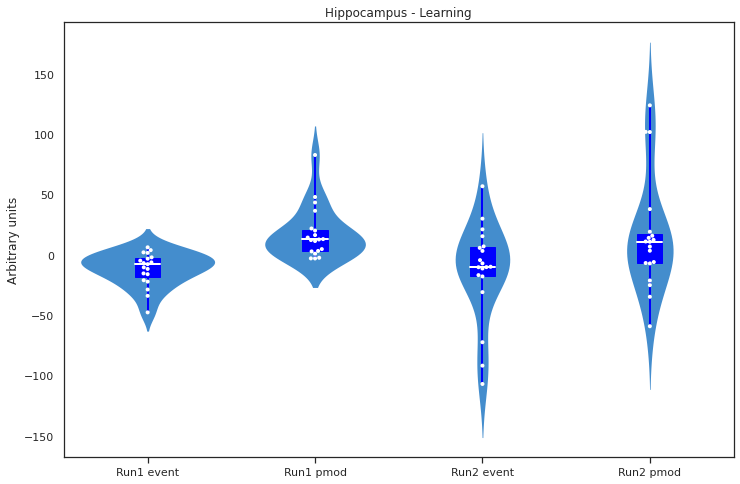

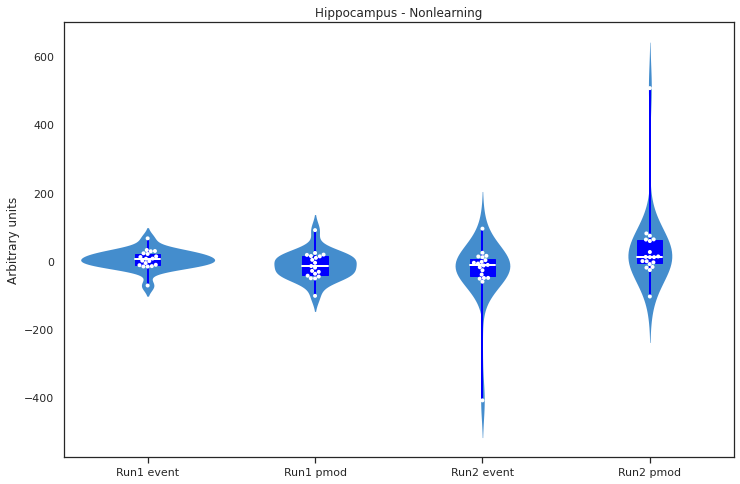

In [8]:
##STEP 8
#Iterate through all conditions to print Mean and STD for each
for d in ['early_learn_event', 'early_learn_pmod', 'late_learn_event', 'late_learn_pmod',
          'early_nonlearn_event', 'early_nonlearn_pmod', 'late_nonlearn_event', 'late_nonlearn_pmod']:
    print("Mean {0}: ".format(d), np.mean(hp_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(hp_chart['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1])
    print("")
print("Early Learning: ", stats.wilcoxon(hp_chart['early_learn_event'], hp_chart['early_learn_pmod'])[:], "**")
early_learn_d = ((np.average(hp_chart['early_learn_event']) - np.average(hp_chart['early_learn_pmod'])) 
    / (sqrt((np.std(hp_chart['early_learn_event'],ddof=1))**2+np.std(hp_chart['early_learn_pmod'],ddof=1)**2)/2))
print("Early Learn Cohen's d = ", early_learn_d)
print("Late Learning: ", stats.wilcoxon(hp_chart['late_learn_event'], hp_chart['late_learn_pmod'])[:])
late_learn_d = ((np.average(hp_chart['late_learn_event']) - np.average(hp_chart['late_learn_pmod'])) 
    / (sqrt((np.std(hp_chart['late_learn_event'],ddof=1))**2+np.std(hp_chart['late_learn_pmod'],ddof=1)**2)/2))
print("Late Learn Cohen's d = ", late_learn_d)
print("Early Nonlearning: ", stats.ttest_rel(hp_chart['early_nonlearn_event'], hp_chart['early_nonlearn_pmod'])[:])
early_nonlearn_d = ((np.average(hp_chart['early_nonlearn_event']) - np.average(hp_chart['early_nonlearn_pmod'])) 
    / (sqrt((np.std(hp_chart['early_nonlearn_event'],ddof=1))**2+np.std(hp_chart['early_nonlearn_pmod'],ddof=1)**2)/2))
print("Early Nonlearn Cohen's d = ", early_nonlearn_d)
print("Late Nonlearning: ", stats.wilcoxon( hp_chart['late_nonlearn_event'], hp_chart['late_nonlearn_pmod'])[:])
late_nonlearn_d = ((np.average(hp_chart['late_nonlearn_event']) - np.average(hp_chart['late_nonlearn_pmod'])) 
    / (sqrt((np.std(hp_chart['late_nonlearn_event'],ddof=1))**2+np.std(hp_chart['late_nonlearn_pmod'],ddof=1)**2)/2))
print("Late Nonlearn Cohen's d = ", late_nonlearn_d)
    
#plot data using box and swarmplots
N = 4
conditions = ['Run1 event', 'Run1 pmod', 'Run2 event', 'Run2 pmod'] #labels
hp_allsubjs = [hp_chart['early_learn_event'], hp_chart['early_learn_pmod'],
               hp_chart['late_learn_event'], hp_chart['late_learn_pmod'], 
               hp_chart['early_nonlearn_event'], hp_chart['early_nonlearn_pmod'], 
               hp_chart['late_nonlearn_event'], hp_chart['late_nonlearn_pmod']] #data to plot
ind = np.arange(N) #number of ticks for x-axis
for i in range(2):
    fig, ax = plt.subplots(figsize = (12,8)) #general plotting parameters (size, number, etc)
    if i == 0:
        sns.violinplot(data=hp_allsubjs[:4], color="#278fea", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(hp_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="blue", facecolor="blue"),
                   whiskerprops=dict(color="blue", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = hp_allsubjs[:4], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) #labels x-axis ticks
        ax.set_title("Hippocampus - Learning") #title to entire plot  
    else:
        sns.violinplot(data=hp_allsubjs[4:], color="#278fea", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(hp_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="blue", facecolor="blue"),
                   whiskerprops=dict(color="blue", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = hp_allsubjs[4:], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) #labels x-axis ticks
        ax.set_title("Hippocampus - Nonlearning") #title to entire plot 
    ax.set_xticks(ind) #draws x-axis ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel("Arbitrary units") #typical label of BOLD activation
    #plt.savefig("/home/arenf001/figs/HPMA_C_hpc{0}.png".format(i+1), dpi = 800)
plt.show() #command to draw plot (also resets if looped)

Shapiro early_event 0.526495635509491
Shapiro late_event 1.2145455002610106e-05
Shapiro early_pmod 0.6380543112754822
Shapiro late_pmod 8.233103471866343e-06
Mean early_event:  -3.412685350760033
STD early_event:  13.119226010015048

Mean early_pmod:  2.6764173146925474
STD early_pmod:  19.585248385745306

Mean late_event:  -21.892459863894864
STD late_event:  48.590081746113015

Mean late_pmod:  27.442188083341247
STD late_pmod:  59.04004112973306

Early - t-test:  (-0.8022512301122939, 0.43287257264814905)
Early Cohen's d =  -0.502833369699121
Late - Wilcoxon:  (43.0, 0.036067962646484375) *
Late Cohen's d =  -1.255987277704821


<ipython-input-9-85a2039477e9>:29: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(hp_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


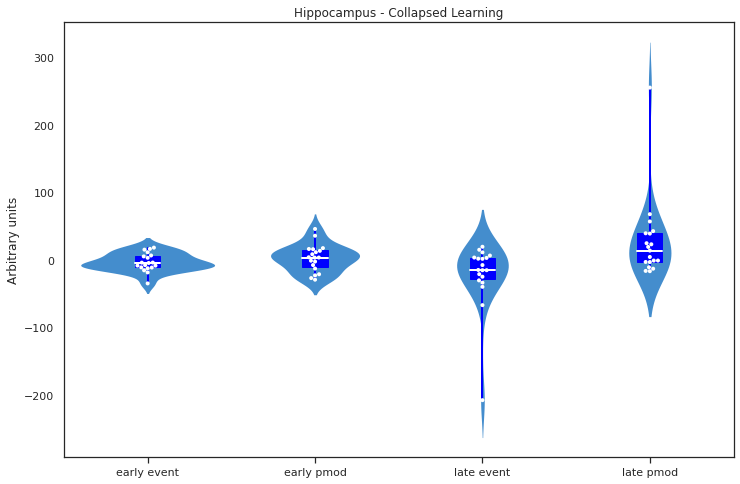

In [9]:
##STEP 9
plot = {}
plot['early_event'] = all_data_df[['hp_all_early_learn_event','hp_all_early_nonlearn_event']].mean(axis=1)
plot['late_event'] = all_data_df[['hp_all_late_learn_event','hp_all_late_nonlearn_event']].mean(axis=1)
plot['early_pmod'] = all_data_df[['hp_all_early_learn_pmod','hp_all_early_nonlearn_pmod']].mean(axis=1)
plot['late_pmod'] = all_data_df[['hp_all_late_learn_pmod','hp_all_late_nonlearn_pmod']].mean(axis=1)
plot_df = pd.DataFrame.from_dict(plot)
for key in plot_df:
    print("Shapiro {0}".format(key), stats.shapiro(plot_df['{0}'.format(key)])[1])
for d in ['early_event', 'early_pmod', 'late_event', 'late_pmod']:
    print("Mean {0}: ".format(d), np.mean(plot['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(plot['{0}'.format(d)]))
    print("")  
print("Early - t-test: ", stats.ttest_rel(plot_df['early_event'], plot_df['early_pmod'])[:])
early_d = ((np.average(plot_df['early_event']) - np.average(plot_df['early_pmod'])) 
    / (sqrt((np.std(plot_df['early_event'],ddof=1))**2+np.std(plot_df['early_pmod'],ddof=1)**2)/2))
print("Early Cohen's d = ", early_d)
print("Late - Wilcoxon: ", stats.wilcoxon(plot_df['late_event'], plot_df['late_pmod'])[:], "*")
late_d = ((np.average(plot_df['late_event']) - np.average(plot_df['late_pmod'])) 
    / (sqrt((np.std(plot_df['late_event'],ddof=1))**2+np.std(plot_df['late_pmod'],ddof=1)**2)/2))
print("Late Cohen's d = ", late_d)
N = 4
conditions = ['early event', 'early pmod', 'late event', 'late pmod']
hp_allsubjs = [plot['early_event'], plot['early_pmod'], plot['late_event'], plot['late_pmod']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (12,8))
sns.violinplot(data=hp_allsubjs, color="#278fea", inner=None, linewidth=0, saturation=0.7)
ax.boxplot(hp_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="blue", facecolor="blue"),
           whiskerprops=dict(color="blue", linewidth=2, linestyle = "-"),
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = hp_allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticks(ind)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampus - Collapsed Learning")
#plt.savefig("/home/arenf001/figs/HPMA_C_hpc.png", dpi = 800)
plt.show()

In [10]:
plot_df

,early_event,late_event,early_pmod,late_pmod
0,-11.043821,-15.271430,15.844699,19.243726
1,-7.690572,-67.039442,-7.632770,67.751130
2,6.552550,19.479526,-2.437785,-16.317122
3,-3.945702,2.923265,3.458830,-3.040508
4,-15.436180,6.464263,17.474208,-10.917403
5,15.185736,-15.260459,-26.957747,23.148086
6,-8.481525,-21.100125,3.878658,24.728681
7,-18.563766,-24.900382,35.859222,42.658827
8,5.183192,-30.330690,-21.244093,39.459384
9,-4.559067,11.181661,8.395414,-13.049707


## mPFC

In [11]:
mpfc_chart = {}
for x in ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
          'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']:
    mpfc_chart['{0}'.format(x)] = all_data_df['mpfc_all_{0}'.format(x)] 
mpfc_chart_df = pd.DataFrame.from_dict(mpfc_chart)

In [12]:
mpfc_chart_df

,early_learn_event,late_learn_event,early_nonlearn_event,late_nonlearn_event,early_learn_pmod,late_learn_pmod,early_nonlearn_pmod,late_nonlearn_pmod
0,-5.132608,12.960270,-45.382105,-36.011097,13.375333,-12.158541,46.960894,44.586344
1,-13.831830,-69.482078,12.366610,-16.262842,16.360478,74.677573,-33.475409,5.390287
2,-4.376578,14.146837,4.530312,103.864233,16.416164,-27.255031,6.659641,-134.428192
3,2.460524,11.811262,-3.838918,14.985931,-0.756908,-13.455908,4.734843,-10.955509
4,-26.922524,0.904800,-8.264850,28.155256,30.526700,-8.383392,4.215240,-42.658012
5,7.123402,21.232935,50.101604,-138.048424,-3.403141,-26.757568,-98.996071,186.081085
6,-15.353563,-79.488075,-93.508167,26.543449,4.145576,81.240620,101.682888,-55.155828
7,-40.863493,-4.909234,-22.929535,-29.184200,78.214674,-4.655535,23.940772,34.653229
8,1.593673,-11.650664,9.394909,-16.417602,-4.318725,18.880252,-42.973160,20.980066
9,-4.026936,56.008068,2.316729,50.750919,10.081343,-64.691675,1.463007,-61.565639


Mean early_learn_event:  -10.38388999041758
STD early_learn_event:  17.426764254200613
Shapiro early_learn_event 0.0018664117669686675

Mean early_learn_pmod:  15.12505031494718
STD early_learn_pmod:  21.882548447989475
Shapiro early_learn_pmod 0.004979061894118786

Mean late_learn_event:  -13.233314948646646
STD late_learn_event:  40.993626654055255
Shapiro late_learn_event 0.17214088141918182

Mean late_learn_pmod:  13.7112132208912
STD late_learn_pmod:  47.26799008954287
Shapiro late_learn_pmod 0.3185003995895386

Mean early_nonlearn_event:  2.1339419186115265
STD early_nonlearn_event:  46.00048791392867
Shapiro early_nonlearn_event 0.5721686482429504

Mean early_nonlearn_pmod:  -9.10255785521708
STD early_nonlearn_pmod:  59.24420795000953
Shapiro early_nonlearn_pmod 0.4772166609764099

Mean late_nonlearn_event:  -4.3078104822259204
STD late_nonlearn_event:  57.297263362001786
Shapiro late_nonlearn_event 0.9632380604743958

Mean late_nonlearn_pmod:  6.981921817127027
STD late_nonlea

<ipython-input-13-6f5544a94ce6>:38: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
<ipython-input-13-6f5544a94ce6>:47: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,


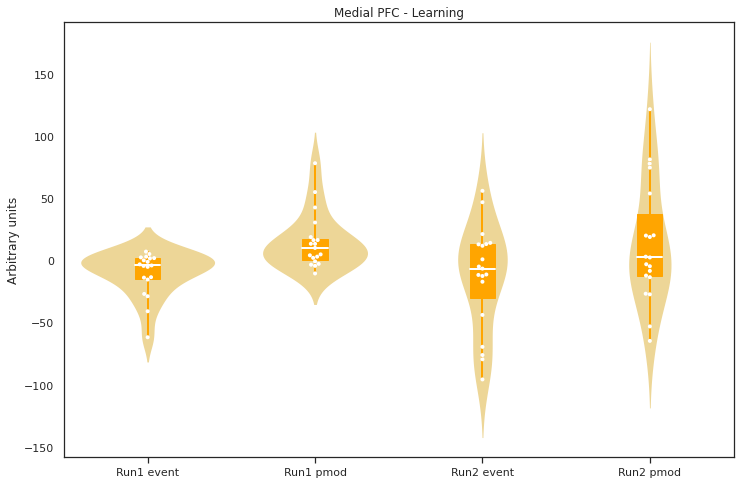

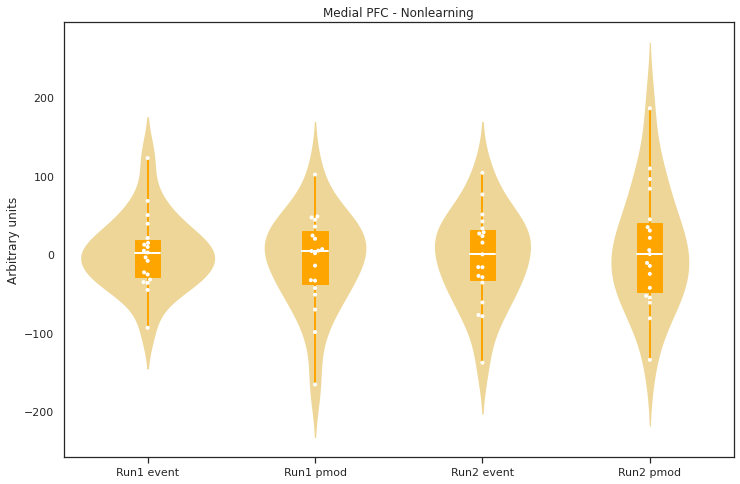

In [13]:
##STEP 8
#Iterate through all conditions to print Mean and STD for each
for d in ['early_learn_event', 'early_learn_pmod', 'late_learn_event', 'late_learn_pmod',
          'early_nonlearn_event', 'early_nonlearn_pmod', 'late_nonlearn_event', 'late_nonlearn_pmod']:
    print("Mean {0}: ".format(d), np.mean(mpfc_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(mpfc_chart['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(mpfc_chart['{0}'.format(d)])[1])
    print("")
print("Early Learning: ", stats.wilcoxon(mpfc_chart['early_learn_event'], mpfc_chart['early_learn_pmod'])[:], "**")
early_learn_d = ((np.average(mpfc_chart['early_learn_event']) - np.average(mpfc_chart['early_learn_pmod'])) 
    / (sqrt((np.std(mpfc_chart['early_learn_event'],ddof=1))**2+np.std(mpfc_chart['early_learn_pmod'],ddof=1)**2)/2))
print("Early Learn Cohen's d = ", early_learn_d)
print("Late Learning: ", stats.ttest_rel(mpfc_chart['late_learn_event'], mpfc_chart['late_learn_pmod'])[:])
late_learn_d = ((np.average(mpfc_chart['late_learn_event']) - np.average(mpfc_chart['late_learn_pmod'])) 
    / (sqrt((np.std(mpfc_chart['late_learn_event'],ddof=1))**2+np.std(mpfc_chart['late_learn_pmod'],ddof=1)**2)/2))
print("Late Learn Cohen's d = ", late_learn_d)
print("Early Nonlearning: ", stats.ttest_rel(mpfc_chart['early_nonlearn_event'], mpfc_chart['early_nonlearn_pmod'])[:])
early_nonlearn_d = ((np.average(mpfc_chart['early_nonlearn_event']) - np.average(mpfc_chart['early_nonlearn_pmod'])) 
    / (sqrt((np.std(mpfc_chart['early_nonlearn_event'],ddof=1))**2+np.std(mpfc_chart['early_nonlearn_pmod'],ddof=1)**2)/2))
print("Early Nonlearn Cohen's d = ", early_nonlearn_d)
print("Late Nonlearning: ", stats.ttest_rel( mpfc_chart['late_nonlearn_event'], mpfc_chart['late_nonlearn_pmod'])[:])
late_nonlearn_d = ((np.average(mpfc_chart['late_nonlearn_event']) - np.average(mpfc_chart['late_nonlearn_pmod'])) 
    / (sqrt((np.std(mpfc_chart['late_nonlearn_event'],ddof=1))**2+np.std(mpfc_chart['late_nonlearn_pmod'],ddof=1)**2)/2))
print("Late Nonlearn Cohen's d = ", late_nonlearn_d)
    
#plot data using box and swarmplots
N = 4
conditions = ['Run1 event', 'Run1 pmod', 'Run2 event', 'Run2 pmod'] #labels
mpfc_allsubjs = [mpfc_chart['early_learn_event'], mpfc_chart['early_learn_pmod'],
                 mpfc_chart['late_learn_event'], mpfc_chart['late_learn_pmod'], 
                 mpfc_chart['early_nonlearn_event'], mpfc_chart['early_nonlearn_pmod'], 
                 mpfc_chart['late_nonlearn_event'], mpfc_chart['late_nonlearn_pmod']] #data to plot
ind = np.arange(N) #number of ticks for x-axis
for i in range(2):
    fig, ax = plt.subplots(figsize = (12,8)) #general plotting parameters (size, number, etc)
    if i == 0:
        sns.violinplot(data=mpfc_allsubjs[:4], color="#ffde85", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(mpfc_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="orange", facecolor="orange"),
                   whiskerprops=dict(color="orange", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = mpfc_allsubjs[:4], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) #labels x-axis ticks
        ax.set_title("Medial PFC - Learning") #title to entire plot  
    else:
        sns.violinplot(data=mpfc_allsubjs[4:], color="#ffde85", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(mpfc_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="orange", facecolor="orange"),
                   whiskerprops=dict(color="orange", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = mpfc_allsubjs[4:], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) #labels x-axis ticks
        ax.set_title("Medial PFC - Nonlearning") #title to entire plot 
    ax.set_xticks(ind) #draws x-axis ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel("Arbitrary units") #typical label of BOLD activation
    #plt.savefig("/home/arenf001/figs/HPMA_C_mpfc{0}.png".format(i+1), dpi = 800)
plt.show() #command to draw plot (also resets if looped)

Mean early_event:  -4.124974035903027
STD early_event:  25.877314324837762
Shapiro early_event 0.960595428943634

Mean late_event:  -8.770562715436283
STD late_event:  37.55530264852952
Shapiro late_event 0.6504899263381958

Mean early_pmod:  3.011246229865049
STD early_pmod:  31.646670696274704
Shapiro early_pmod 0.7357884645462036

Mean late_pmod:  10.346567519009113
STD late_pmod:  44.994233748119406
Shapiro late_pmod 0.7486765384674072

Early - Event vs. Pmod t-test:  (-0.5325765429868419, 0.6008402341317759)
Early Cohen's d =  -0.33982110379609076
Late - Event vs. Pmod t-test:  (-0.9867140271778418, 0.3368616016477701)
Late Cohen's d =  -0.6349744438100793


<ipython-input-14-e37f3b8c707e>:28: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


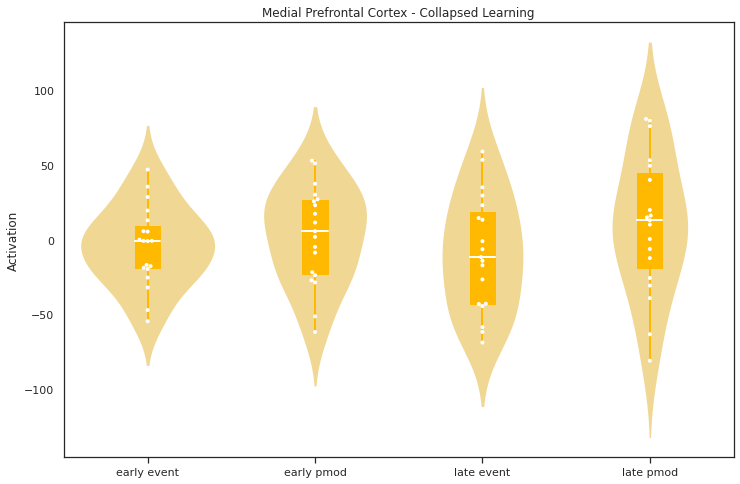

In [14]:
plot2 = {}
plot2['early_event'] = all_data_df[['mpfc_all_early_learn_event','mpfc_all_early_nonlearn_event']].mean(axis=1)
plot2['late_event'] = all_data_df[['mpfc_all_late_learn_event','mpfc_all_late_nonlearn_event']].mean(axis=1)
plot2['early_pmod'] = all_data_df[['mpfc_all_early_learn_pmod','mpfc_all_early_nonlearn_pmod']].mean(axis=1)
plot2['late_pmod'] = all_data_df[['mpfc_all_late_learn_pmod','mpfc_all_late_nonlearn_pmod']].mean(axis=1)
plot2_df = pd.DataFrame.from_dict(plot2)
for d in ['early_event', 'late_event', 'early_pmod', 'late_pmod']:
    print("Mean {0}: ".format(d), np.mean(plot2['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(plot2['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(plot2['{0}'.format(d)])[1])
    print("")    
print("Early - Event vs. Pmod t-test: ", stats.ttest_rel(plot2['early_event'], plot2['early_pmod'])[:])
early_d = ((np.average(plot2_df['early_event']) - np.average(plot2_df['early_pmod'])) 
    / (sqrt((np.std(plot2_df['early_event'],ddof=1))**2+np.std(plot2_df['early_pmod'],ddof=1)**2)/2))
print("Early Cohen's d = ", early_d)
print("Late - Event vs. Pmod t-test: ", stats.ttest_rel(plot2['late_event'], plot2['late_pmod'])[:]) 
late_d = ((np.average(plot2_df['late_event']) - np.average(plot2_df['late_pmod'])) 
    / (sqrt((np.std(plot2_df['late_event'],ddof=1))**2+np.std(plot2_df['late_pmod'],ddof=1)**2)/2))
print("Late Cohen's d = ", late_d)
N = 4
N = 4
conditions = ['early event', 'early pmod', 'late event', 'late pmod']
mpfc_allsubjs = [plot2['early_event'], plot2['early_pmod'], plot2['late_event'], plot2['late_pmod']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (12,8))
sns.violinplot(data=mpfc_allsubjs, color="#ffde85", inner=None, linewidth=0)
ax.boxplot(mpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="#ffb900", facecolor="#ffb900"),
           whiskerprops=dict(color="#ffb900", linewidth=2, linestyle = "-"), 
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = mpfc_allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticks(ind)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.set_title("Medial Prefrontal Cortex - Collapsed Learning")
#plt.savefig("/home/arenf001/figs/HPMA_C_mpfc.png", dpi = 800)
plt.show()

## Caudate

In [15]:
caud_chart = {}
for x in ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
          'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']:
    caud_chart['{0}'.format(x)] = all_data_df['caud_all_{0}'.format(x)] 
caud_chart_df = pd.DataFrame.from_dict(caud_chart)

In [16]:
caud_chart_df

,early_learn_event,late_learn_event,early_nonlearn_event,late_nonlearn_event,early_learn_pmod,late_learn_pmod,early_nonlearn_pmod,late_nonlearn_pmod
0,3.079532,1.950643,69.831974,-62.632181,7.030560,-3.395723,-91.765629,80.256355
1,-9.401809,229.504723,-5.494323,-25.997878,5.785127,-246.411461,-12.280948,24.261861
2,13.720494,39.501059,2.722639,106.717922,-10.247480,-61.242502,4.227415,-137.615601
3,1.259097,30.038021,8.293297,22.884576,7.618940,-34.472549,-9.034200,-27.789728
4,-0.979716,-38.651548,-23.152802,14.081263,-2.238307,46.513494,21.659341,-27.700897
5,0.619157,-16.222487,58.602581,-130.954441,8.250780,17.206094,-95.556042,182.192459
6,13.697860,-38.210814,-5.431174,52.733884,-21.001181,40.607235,-6.791260,-75.578638
7,20.785077,11.259227,-19.298777,0.733158,-54.990028,-23.029606,38.464527,3.881832
8,13.844355,-6.019594,17.355127,11.481378,-20.791125,6.073027,-30.531789,-13.155337
9,18.165871,31.897732,15.299279,-19.214389,-20.773715,-34.781343,-30.885076,38.746483


Mean early_learn_event:  3.380923018055527
STD early_learn_event:  25.19641545498866
Shapiro early_learn_event 0.002804645337164402

Mean early_learn_pmod:  -1.0406276897380227
STD early_learn_pmod:  37.5093141689636
Shapiro early_learn_pmod 0.0029587349854409695

Mean late_learn_event:  5.225429097288533
STD late_learn_event:  69.17556479062962
Shapiro late_learn_event 0.008444061502814293

Mean late_learn_pmod:  -6.340441620173423
STD late_learn_pmod:  79.62910694389862
Shapiro late_learn_pmod 0.03172169253230095

Mean early_nonlearn_event:  22.060947330374468
STD early_nonlearn_event:  34.701859570863995
Shapiro early_nonlearn_event 0.12646827101707458

Mean early_nonlearn_pmod:  -30.958848841880496
STD early_nonlearn_pmod:  46.36614077537778
Shapiro early_nonlearn_pmod 0.6626073122024536

Mean late_nonlearn_event:  6.167365478841882
STD late_nonlearn_event:  54.95511491478276
Shapiro late_nonlearn_event 0.5667791962623596

Mean late_nonlearn_pmod:  -3.684233085889565
STD late_nonle

<ipython-input-17-7996d9edb8fe>:37: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(caud_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
<ipython-input-17-7996d9edb8fe>:46: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(caud_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,


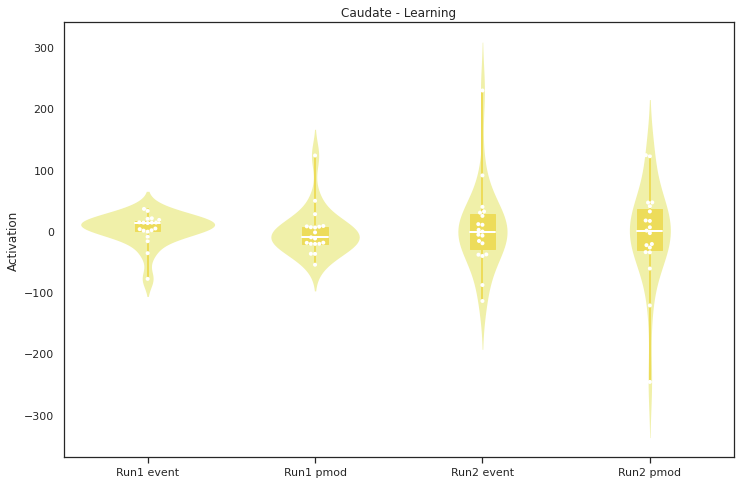

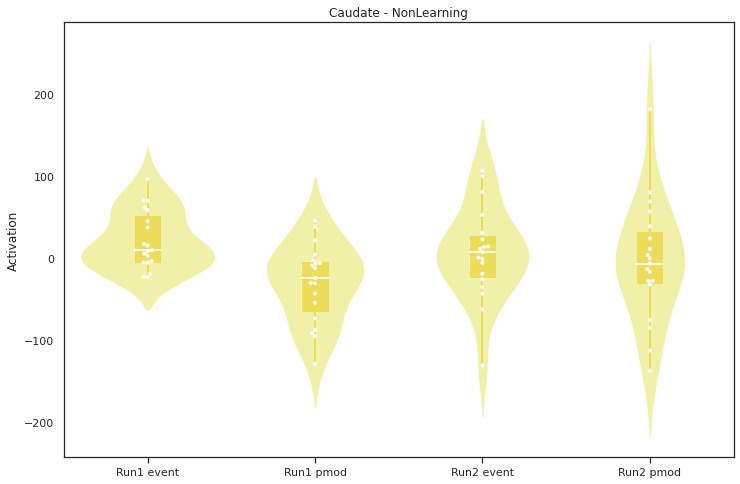

In [17]:
for d in ['early_learn_event', 'early_learn_pmod', 'late_learn_event', 'late_learn_pmod',
          'early_nonlearn_event', 'early_nonlearn_pmod', 'late_nonlearn_event', 'late_nonlearn_pmod']:
    print("Mean {0}: ".format(d), np.mean(caud_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(caud_chart['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(caud_chart['{0}'.format(d)])[1])
    print("")
print("Early Learning: ", stats.wilcoxon(caud_chart['early_learn_event'], caud_chart['early_learn_pmod'])[:])
early_learn_d = ((np.average(caud_chart['early_learn_event']) - np.average(caud_chart['early_learn_pmod'])) 
    / (sqrt((np.std(caud_chart['early_learn_event'],ddof=1))**2+np.std(caud_chart['early_learn_pmod'],ddof=1)**2)/2))
print("Early Learn Cohen's d = ", early_learn_d)
print("Late Learning: ", stats.wilcoxon(caud_chart['late_learn_event'], caud_chart['late_learn_pmod'])[:])
late_learn_d = ((np.average(caud_chart['late_learn_event']) - np.average(caud_chart['late_learn_pmod'])) 
    / (sqrt((np.std(caud_chart['late_learn_event'],ddof=1))**2+np.std(caud_chart['late_learn_pmod'],ddof=1)**2)/2))
print("Late Learn Cohen's d = ", late_learn_d)
print("Early Nonlearning: ", stats.ttest_rel(caud_chart['early_nonlearn_event'], caud_chart['early_nonlearn_pmod'])[:],"**")
early_nonlearn_d = ((np.average(caud_chart['early_nonlearn_event']) - np.average(caud_chart['early_nonlearn_pmod'])) 
    / (sqrt((np.std(caud_chart['early_nonlearn_event'],ddof=1))**2+np.std(caud_chart['early_nonlearn_pmod'],ddof=1)**2)/2))
print("Early Nonlearn Cohen's d = ", early_nonlearn_d)
print("Late Nonlearning: ", stats.ttest_rel( caud_chart['late_nonlearn_event'], caud_chart['late_nonlearn_pmod'])[:])
late_nonlearn_d = ((np.average(caud_chart['late_nonlearn_event']) - np.average(caud_chart['late_nonlearn_pmod'])) 
    / (sqrt((np.std(caud_chart['late_nonlearn_event'],ddof=1))**2+np.std(caud_chart['late_nonlearn_pmod'],ddof=1)**2)/2))
print("Late Nonlearn Cohen's d = ", late_nonlearn_d)
    
#plot data using box and swarmplots
N = 4
conditions = ['Run1 event', 'Run1 pmod', 'Run2 event', 'Run2 pmod'] #labels

caud_allsubjs = [caud_chart['early_learn_event'], caud_chart['early_learn_pmod'],
                 caud_chart['late_learn_event'], caud_chart['late_learn_pmod'], 
                 caud_chart['early_nonlearn_event'], caud_chart['early_nonlearn_pmod'], 
                 caud_chart['late_nonlearn_event'], caud_chart['late_nonlearn_pmod']] #data to plot
ind = np.arange(N)
for i in range(2):
    fig, ax = plt.subplots(figsize = (12,8)) 
    if i == 0:
        sns.violinplot(data=caud_allsubjs[:4], color="#fcfc9d", inner=None, linewidth=0)
        ax.boxplot(caud_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="#eddc5a", facecolor="#eddc5a"),
                   whiskerprops=dict(color="#eddc5a", linewidth=2, linestyle = "-"), 
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = caud_allsubjs[:4], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) 
        ax.set_title("Caudate - Learning")         
    else:
        sns.violinplot(data=caud_allsubjs[4:], color="#fcfc9d", inner=None, linewidth=0)
        ax.boxplot(caud_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="#eddc5a", facecolor="#eddc5a"),
                   whiskerprops=dict(color="#eddc5a", linewidth=2, linestyle = "-"), 
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = caud_allsubjs[4:], size = 4, color = "white", edgecolor = "gray") 
        ax.set_xticklabels(conditions)
        ax.set_title("Caudate - NonLearning") 
    ax.set_xticks(ind) 
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel("Activation") 
    #plt.savefig("/home/arenf001/figs/HPMA_C_caud{0}.png".format(i+1), dpi = 800)
plt.show() 

Mean early_event:  12.720935174214997
STD early_event:  18.978713945331616
Shapiro early_event 0.9258884787559509

Mean late_event:  5.696397288065207
STD late_event:  41.63543111826445
Shapiro late_event 0.0785011425614357

Mean early_pmod:  -15.99973826580926
STD early_pmod:  22.670604852255174
Shapiro early_pmod 0.8954445123672485

Mean late_pmod:  -5.012337353031494
STD late_pmod:  52.2410063331316
Shapiro late_pmod 0.09417629987001419

Early - Event vs. Pmod Wilcoxon:  (31.0, 0.00823211669921875) **
Early Cohen's d =  1.8910003342234807
Late - Event vs. Pmod Wilcoxon:  (95.0, 1.0)
Late Cohen's d =  0.3120556667958951


<ipython-input-18-de0e452eb48a>:29: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(caud_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


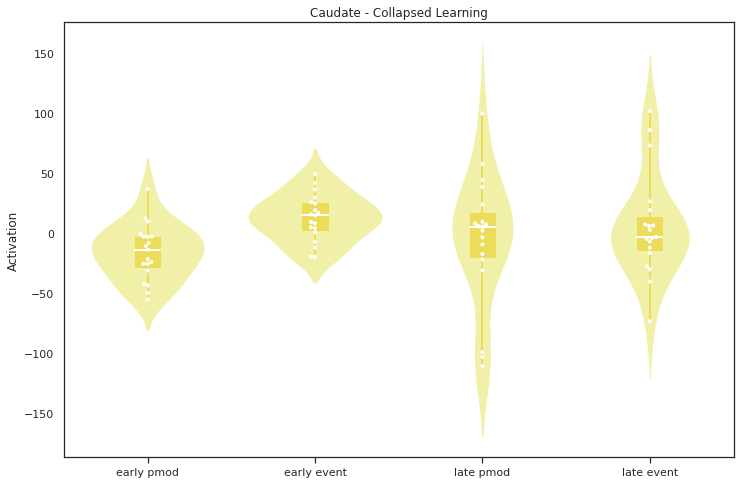

In [18]:
plot3 = {}
plot3['early_event'] = all_data_df[['caud_all_early_learn_event','caud_all_early_nonlearn_event']].mean(axis=1)
plot3['late_event'] = all_data_df[['caud_all_late_learn_event','caud_all_late_nonlearn_event']].mean(axis=1)
plot3['early_pmod'] = all_data_df[['caud_all_early_learn_pmod','caud_all_early_nonlearn_pmod']].mean(axis=1)
plot3['late_pmod'] = all_data_df[['caud_all_late_learn_pmod','caud_all_late_nonlearn_pmod']].mean(axis=1)
plot3_df = pd.DataFrame.from_dict(plot3)

for d in ['early_event', 'late_event', 'early_pmod', 'late_pmod']:
    print("Mean {0}: ".format(d), np.mean(plot3['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(plot3['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(plot3['{0}'.format(d)])[1])
    print("")    
print("Early - Event vs. Pmod Wilcoxon: ", stats.wilcoxon(plot3['early_event'], plot3['early_pmod'])[:], "**")
early_d = ((np.average(plot3_df['early_event']) - np.average(plot3_df['early_pmod'])) 
          / (sqrt((np.std(plot3_df['early_event'],ddof=1))**2+np.std(plot3_df['early_pmod'],ddof=1)**2)/2))
print("Early Cohen's d = ", early_d)
print("Late - Event vs. Pmod Wilcoxon: ", stats.wilcoxon(plot3['late_event'], plot3['late_pmod'])[:])
late_d = ((np.average(plot3_df['late_event']) - np.average(plot3_df['late_pmod'])) 
          / (sqrt((np.std(plot3_df['late_event'],ddof=1))**2+np.std(plot3_df['late_pmod'],ddof=1)**2)/2))
print("Late Cohen's d = ", late_d)
                       
N = 4
conditions = ['early pmod', 'early event', 'late pmod', 'late event']
caud_allsubjs = [plot3['early_pmod'], plot3['early_event'], plot3['late_pmod'], plot3['late_event']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (12,8))
sns.violinplot(data=caud_allsubjs, color="#fcfc9d", inner=None, linewidth=0)
ax.boxplot(caud_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="#eddc5a", facecolor="#eddc5a"),
           whiskerprops=dict(color="#eddc5a", linewidth=2, linestyle = "-"), 
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = caud_allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticklabels(conditions)
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Activation")
ax.set_title("Caudate - Collapsed Learning")
#plt.savefig("/home/arenf001/figs/HPMA_C_caud.png", dpi = 800)
plt.show()

In [19]:
plot3_df

,early_event,late_event,early_pmod,late_pmod
0,36.455753,-30.340769,-42.367534,38.430316
1,-7.448066,101.753422,-3.247910,-111.074800
2,8.221566,73.109490,-3.010033,-99.429051
3,4.776197,26.461298,-0.707630,-31.131139
4,-12.066259,-12.285143,9.710517,9.406299
5,29.610869,-73.588464,-43.652631,99.699276
6,4.133343,7.261535,-13.896221,-17.485702
7,0.743150,5.996193,-8.262751,-9.573887
8,15.599741,2.730892,-25.661457,-3.541155
9,16.732575,6.341671,-25.829395,1.982570


## Putamen

In [20]:
put_chart = {}
for x in ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
          'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']:
    put_chart['{0}'.format(x)] = all_data_df['put_all_{0}'.format(x)] 
put_chart_df = pd.DataFrame.from_dict(put_chart)

In [21]:
put_chart_df

,early_learn_event,late_learn_event,early_nonlearn_event,late_nonlearn_event,early_learn_pmod,late_learn_pmod,early_nonlearn_pmod,late_nonlearn_pmod
0,3.439766,-20.280822,15.079742,-39.990684,2.295642,22.295624,-9.848835,52.345461
1,-16.963058,292.650803,-4.896729,-23.377164,9.590623,-312.572327,-16.662125,19.650609
2,10.277487,48.900759,-31.493476,132.558601,-7.142843,-63.524355,39.000214,-164.050110
3,-6.491493,12.536222,0.437196,16.666246,6.565575,-15.041692,-2.389306,-20.473174
4,-9.208562,-33.712011,-22.831304,13.902010,12.080317,38.194752,29.653115,-19.448457
5,-5.757187,-22.150387,26.479102,-144.559502,13.171054,25.638995,-48.878040,195.386307
6,14.182619,-55.292168,-4.611207,62.695263,-27.710215,65.914989,-7.153493,-90.160164
7,6.718658,-1.974208,11.596615,-19.660119,-27.173349,-2.876667,-28.787988,48.163349
8,4.815504,-6.666912,-7.273701,-9.291648,-5.846222,11.469687,-10.578160,14.971749
9,-5.471141,37.091991,0.677007,19.706701,12.021962,-42.405750,-0.350564,-20.221033


Mean early_learn_event:  -2.872644285622396
STD early_learn_event:  17.071441587772096
Shapiro early_learn_event 0.038540806621313095

Mean early_learn_pmod:  5.113686560015929
STD early_learn_pmod:  26.468376925075944
Shapiro early_learn_pmod 0.003636273555457592

Mean late_learn_event:  8.972460349139414
STD late_learn_event:  74.59036955139582
Shapiro late_learn_event 3.10779178107623e-05

Mean late_learn_pmod:  -9.663097810416826
STD late_learn_pmod:  82.56252016306507
Shapiro late_learn_pmod 0.00016297570255119354

Mean early_nonlearn_event:  10.9370801919385
STD early_nonlearn_event:  24.650485527293956
Shapiro early_nonlearn_event 0.3968184292316437

Mean early_nonlearn_pmod:  -18.796182749302762
STD early_nonlearn_pmod:  33.95841755331978
Shapiro early_nonlearn_pmod 0.5052081346511841

Mean late_nonlearn_event:  -0.6300757697930461
STD late_nonlearn_event:  51.44346149629362
Shapiro late_nonlearn_event 0.027090374380350113

Mean late_nonlearn_pmod:  3.49153879441713
STD late_no

<ipython-input-22-11274276d804>:36: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
<ipython-input-22-11274276d804>:45: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,


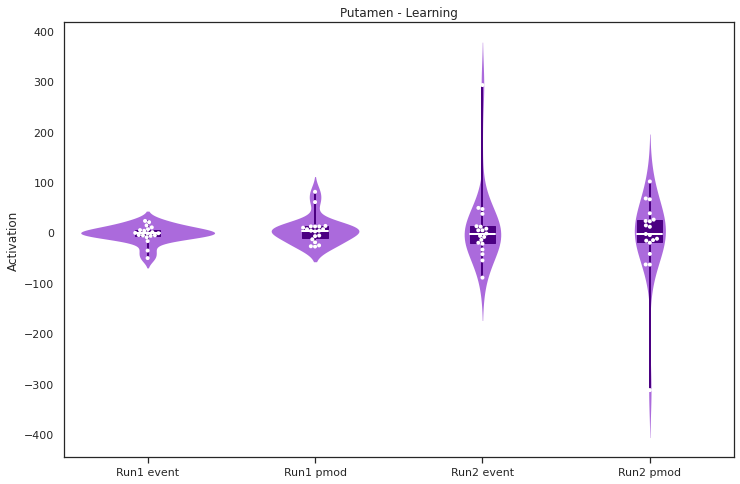

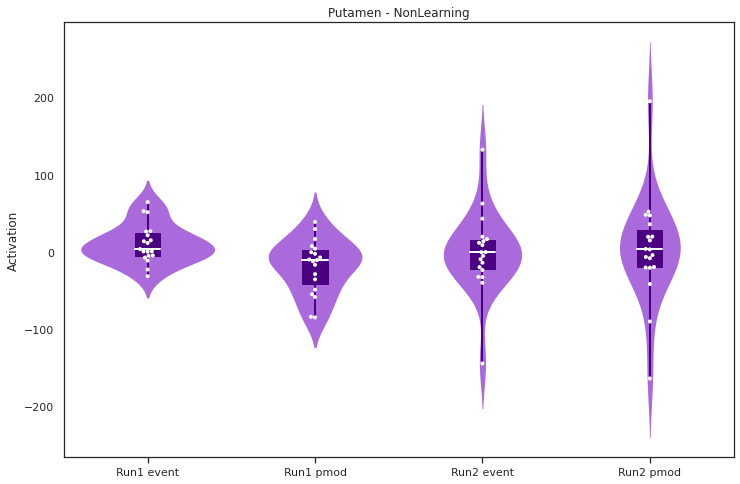

In [22]:
for d in ['early_learn_event', 'early_learn_pmod', 'late_learn_event', 'late_learn_pmod',
          'early_nonlearn_event', 'early_nonlearn_pmod', 'late_nonlearn_event', 'late_nonlearn_pmod']:
    print("Mean {0}: ".format(d), np.mean(put_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(put_chart['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(put_chart['{0}'.format(d)])[1])
    print("")
print("Early Learning: ", stats.wilcoxon(put_chart['early_learn_event'], put_chart['early_learn_pmod'])[:])
early_learn_d = ((np.average(put_chart['early_learn_event']) - np.average(put_chart['early_learn_pmod'])) 
    / (sqrt((np.std(put_chart['early_learn_event'],ddof=1))**2+np.std(put_chart['early_learn_pmod'],ddof=1)**2)/2))
print("Early Learn Cohen's d = ", early_learn_d)
print("Late Learning: ", stats.wilcoxon(put_chart['late_learn_event'], put_chart['late_learn_pmod'],)[:])
late_learn_d = ((np.average(put_chart['late_learn_event']) - np.average(put_chart['late_learn_pmod'])) 
    / (sqrt((np.std(put_chart['late_learn_event'],ddof=1))**2+np.std(put_chart['late_learn_pmod'],ddof=1)**2)/2))
print("Late Learn Cohen's d = ", late_learn_d)
print("Early Nonlearning: ", stats.ttest_rel(put_chart['early_nonlearn_event'], put_chart['early_nonlearn_pmod'])[:], "*")
early_nonlearn_d = ((np.average(put_chart['early_nonlearn_event']) - np.average(put_chart['early_nonlearn_pmod'])) 
    / (sqrt((np.std(put_chart['early_nonlearn_event'],ddof=1))**2+np.std(put_chart['early_nonlearn_pmod'],ddof=1)**2)/2))
print("Early Nonlearn Cohen's d = ", early_nonlearn_d)
print("Late Nonlearning: ", stats.wilcoxon(put_chart['late_nonlearn_event'], put_chart['late_nonlearn_pmod'])[:])
late_nonlearn_d = ((np.average(put_chart['late_nonlearn_event']) - np.average(put_chart['late_nonlearn_pmod'])) 
    / (sqrt((np.std(put_chart['late_nonlearn_event'],ddof=1))**2+np.std(put_chart['late_nonlearn_pmod'],ddof=1)**2)/2))
print("Late Nonlearn Cohen's d = ", late_nonlearn_d)
#plot data using box and swarmplots
N = 4
conditions = ['Run1 event', 'Run1 pmod', 'Run2 event', 'Run2 pmod'] #labels
put_allsubjs = [put_chart['early_learn_event'], put_chart['early_learn_pmod'],
                put_chart['late_learn_event'], put_chart['late_learn_pmod'], 
                put_chart['early_nonlearn_event'], put_chart['early_nonlearn_pmod'], 
                put_chart['late_nonlearn_event'], put_chart['late_nonlearn_pmod']] #data to plot

ind = np.arange(N)
for i in range(2):
    fig, ax = plt.subplots(figsize = (12,8)) 
    if i == 0:
        sns.violinplot(data=put_allsubjs[:4], color="#af52f4", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(put_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="indigo", facecolor="indigo"),
                   whiskerprops=dict(color="indigo", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = put_allsubjs[:4], size = 4, color = "white", edgecolor = "gray")           
        ax.set_xticklabels(conditions) 
        ax.set_title("Putamen - Learning")         
    else:
        sns.violinplot(data=put_allsubjs[4:], color="#af52f4", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(put_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="indigo", facecolor="indigo"),
                   whiskerprops=dict(color="indigo", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = put_allsubjs[4:], size = 4, color = "white", edgecolor = "gray")           
        ax.set_xticklabels(conditions)
        ax.set_title("Putamen - NonLearning") 
    ax.set_xticks(ind)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel("Activation") 
    #plt.savefig("/home/arenf001/figs/HPMA_C_put{0}.png".format(i+1), dpi = 800)
plt.show() 

early_event Mean:  4.032217953158052
early_event STD:  12.578312098931946
Shapiro early_event 0.3233433961868286

late_event Mean:  4.171192289673184
late_event STD:  44.295326454379676
Shapiro late_event 0.0035481522791087627

early_pmod Mean:  -6.841248094643417
early_pmod STD:  17.232676570257844
Shapiro early_pmod 0.47820422053337097

late_pmod Mean:  -3.0857795079998476
late_pmod STD:  53.391538164256225
Shapiro late_pmod 0.014236467890441418

Early - Event vs. Pmod Wilcoxon:  (59.0, 0.156402587890625)
Early Cohen's d =  0.9921247983379553
Late - Event vs. Pmod Wilcoxon:  (85.0, 0.70855712890625)
Late Cohen's d =  0.2036334084547316


<ipython-input-23-6d5790da2dda>:31: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


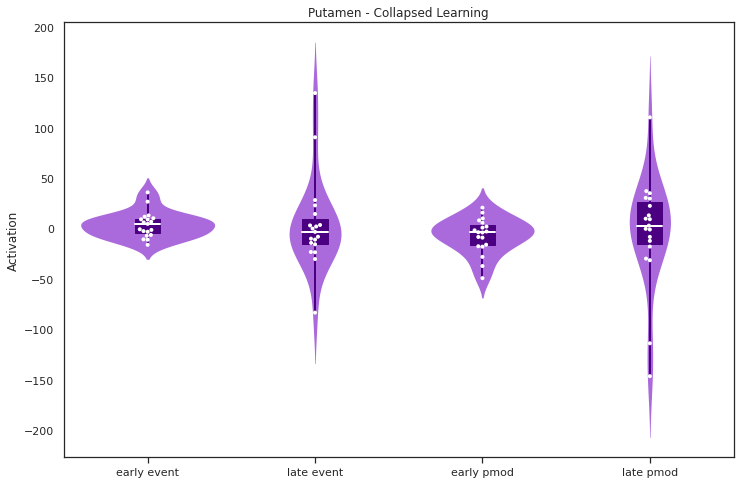

In [23]:
plot4 = {}
plot4['early_event'] = all_data_df[['put_all_early_learn_event','put_all_early_nonlearn_event']].mean(axis=1)
plot4['late_event'] = all_data_df[['put_all_late_learn_event','put_all_late_nonlearn_event']].mean(axis=1)
plot4['early_pmod'] = all_data_df[['put_all_early_learn_pmod','put_all_early_nonlearn_pmod']].mean(axis=1)
plot4['late_pmod'] = all_data_df[['put_all_late_learn_pmod','put_all_late_nonlearn_pmod']].mean(axis=1)
plot4_df = pd.DataFrame.from_dict(plot4)

for d in ['early_event', 'late_event', 'early_pmod', 'late_pmod']:
    print("{0} Mean: ".format(d), np.mean(plot4['{0}'.format(d)]))
    print("{0} STD: ".format(d), np.std(plot4['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(plot4['{0}'.format(d)])[1])
    print("")
    
print("Early - Event vs. Pmod Wilcoxon: ", stats.wilcoxon(plot4['early_event'], plot4['early_pmod'])[:])
early_d = ((np.average(plot4['early_event']) - np.average(plot4['early_pmod'])) 
            / (sqrt((np.std(plot4['early_event'],ddof=1))**2+np.std(plot4['early_pmod'],ddof=1)**2)/2))
print("Early Cohen's d = ", early_d)
print("Late - Event vs. Pmod Wilcoxon: ", stats.wilcoxon(plot4['late_event'], plot4['late_pmod'])[:])
late_d = ((np.average(plot4['late_event']) - np.average(plot4['late_pmod'])) 
        / (sqrt((np.std(plot4['late_event'],ddof=1))**2+np.std(plot4['late_pmod'],ddof=1)**2)/2))
print("Late Cohen's d = ", late_d)
                       
N = 4
conditions = ['early event', 'late event', 'early pmod', 'late pmod']
put_allsubjs = [plot4['early_event'], plot4['late_event'], 
                plot4['early_pmod'], plot4['late_pmod']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (12,8))
sns.violinplot(data=put_allsubjs, color="#af52f4", inner=None, linewidth=0, saturation=0.7)
ax.boxplot(put_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="indigo", facecolor="indigo"),
           whiskerprops=dict(color="indigo", linewidth=2, linestyle = "-"),
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = put_allsubjs, size = 4, color = "white", edgecolor = "gray")           
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Activation")
ax.set_title("Putamen - Collapsed Learning")
#plt.savefig("/home/arenf001/figs/HPMA_C_put.png", dpi = 800)
plt.show()